In [128]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

# Read Data

In [146]:
columns_ = ['total_sales',  'is_holiday' ,'node', 'dept_nbr', 'cl_nbr', 'sub_cl_nbr', 'subclass_id', 'beginning_of_week']
data_test=pd.read_csv('data_test_prepared_level1.csv', usecols = columns_  )
data=pd.read_csv('data_train_prepared_level1.csv', usecols = columns_  )
print(data_test.shape , data.shape)
frames = [data, data_test]
data = pd.concat(frames)
data.beginning_of_week.tail(5)

(144156, 8) (15713004, 8)


144151    2020-07-05
144152    2020-07-05
144153    2020-07-05
144154    2020-07-05
144155    2020-07-05
Name: beginning_of_week, dtype: object

In [148]:
data['total_sales'].value_counts().head(4)

0.0000    11368259
1.0000      482192
2.0000      446339
4.0000      292401
Name: total_sales, dtype: int64

# Range of our data

In [149]:
data.beginning_of_week.min(), data.beginning_of_week.max()

('2018-06-03', '2020-07-05')

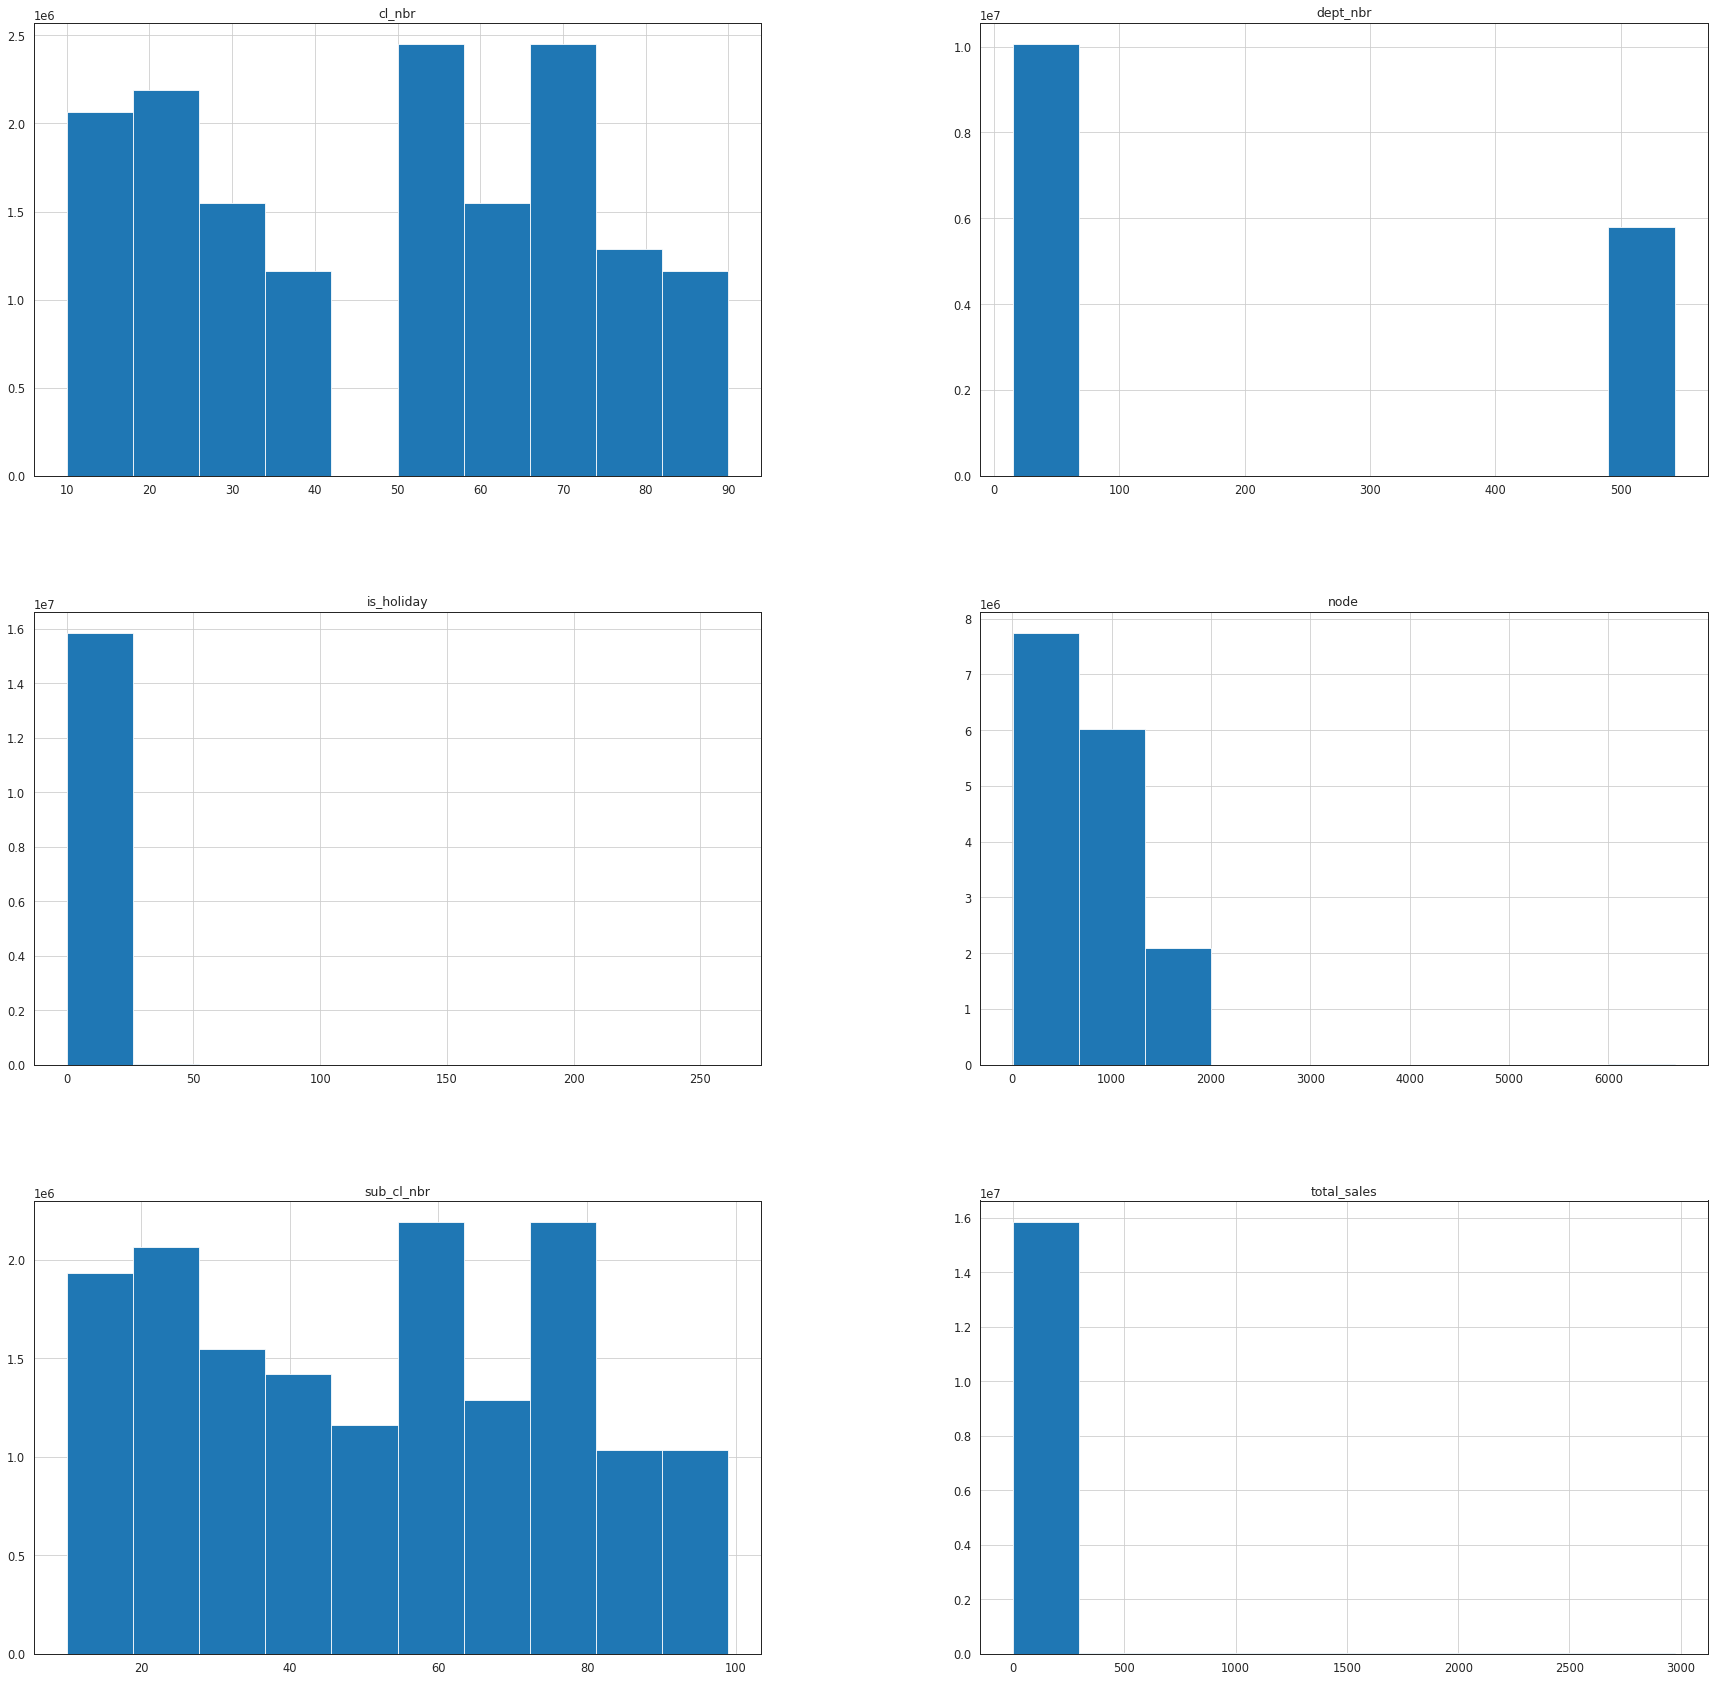

In [150]:
from matplotlib import pyplot

fig = plt.figure(figsize = (30,30))
ax = fig.gca()
data.hist(ax = ax)
pyplot.show()



In [151]:
data.total_sales = data.total_sales.astype(int)

In [152]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15857160 entries, 0 to 144155
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   total_sales        int64  
 1   is_holiday         int64  
 2   node               int64  
 3   dept_nbr           float64
 4   cl_nbr             int64  
 5   sub_cl_nbr         int64  
 6   subclass_id        object 
 7   beginning_of_week  object 
dtypes: float64(1), int64(5), object(2)
memory usage: 1.7+ GB


# transform date to week , year and month

In [153]:
import datetime
import pandas as pd
import numpy as np
data['beginning_of_week'] = pd.to_datetime( data['beginning_of_week'] , format='%Y-%m-%d')
def extract_date(col):
        # make the new columns using string indexing
        data['year'] = data[col].dt.year
        data['month'] = data[col].dt.month
#         data['day'] = data[col].dt.day
        data['quarter']=pd.to_datetime(data[col]).dt.quarter
#         data['smester']=np.where(data.quarter.isin([1,2]), 1 , 2)
#         data['day_of_year']=pd.to_datetime(data[col]).dt.dayofyear
        data['week_of_year']=pd.to_datetime(data[col]).dt.weekofyear
#         data['day_in_Month']=pd.to_datetime(data[col]).dt.days_in_month
        
extract_date('beginning_of_week')

In [154]:
print('Number of rows and columns :', data.shape)
print('The time series starts from: ', data.beginning_of_week.min())
print('The time series ends on: ', data.beginning_of_week.max())

Number of rows and columns : (15857160, 12)
The time series starts from:  2018-06-03 00:00:00
The time series ends on:  2020-07-05 00:00:00


In [155]:
len(data.node.value_counts()) , len(data.sub_cl_nbr.value_counts())

(1172, 80)

# Select randomly 20 subclass below

In [156]:
list_=[12, 13, 14, 21, 27, 34, 35, 38, 45, 49, 50, 51, 52, 53, 61, 63, 64, 72, 73, 86]

In [157]:
train = data[0:15713004]
test = data[15713004:]

train.shape , test.shape

((15713004, 12), (144156, 12))

In [158]:
train=train.loc[train['sub_cl_nbr'].isin(list_)]
test=test.loc[test['sub_cl_nbr'].isin(list_)]
train.shape , test.shape

((3960188, 12), (36332, 12))

In [159]:
data=data.loc[data['sub_cl_nbr'].isin(list_)]


In [166]:
data.sub_cl_nbr.unique()

array([12, 13, 14, 21, 27, 34, 35, 50, 51, 52, 53, 61, 63, 64, 72, 73, 86,
       45])

# lineplot base on Train data

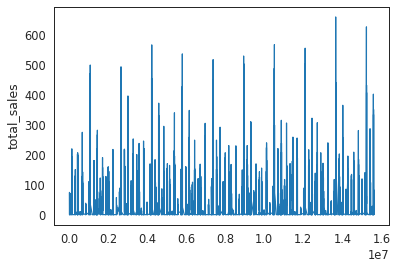

In [160]:
sns.lineplot(x=train['sub_cl_nbr'].index , y = train['total_sales'] , data= train)

# lineplot base on Test data

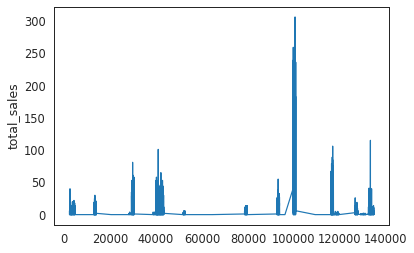

In [161]:
sns.lineplot(x=test['sub_cl_nbr'].index , y = test['total_sales'] , data= test)

# lineplot base on entire data

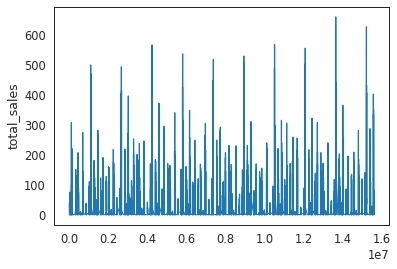

In [162]:
sns.lineplot(x=data['sub_cl_nbr'].index , y = data['total_sales'] , data= test)

In [163]:
data.columns

Index(['total_sales', 'is_holiday', 'node', 'dept_nbr', 'cl_nbr', 'sub_cl_nbr',
       'subclass_id', 'beginning_of_week', 'year', 'month', 'quarter',
       'week_of_year'],
      dtype='object')

In [169]:
def is_holiday_func(col):
        data[col] = data[[col]].applymap(lambda x: 1 if x > 1 else 0)
        data[col].value_counts()

        
is_holiday_func('is_holiday')

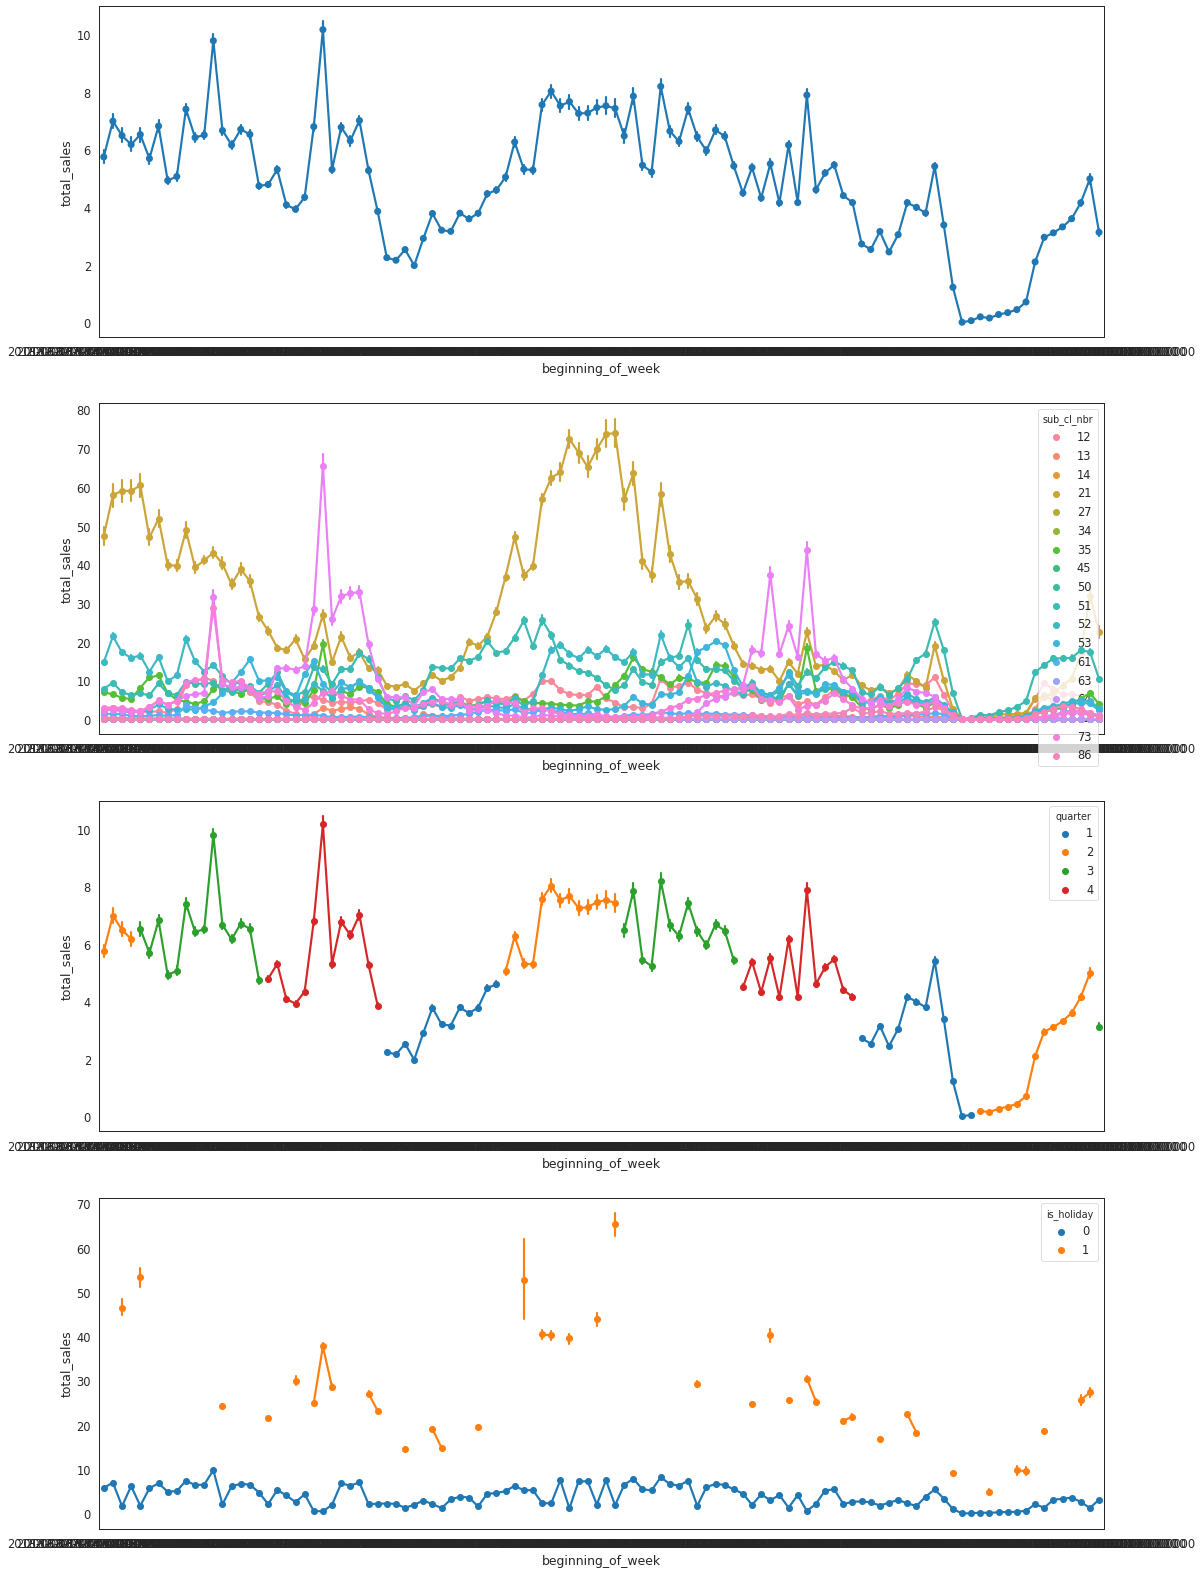

In [170]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)
sns.pointplot(data=data, x='beginning_of_week', y='total_sales', ax=ax1)
sns.pointplot(data=data, x='beginning_of_week', y='total_sales', hue='sub_cl_nbr', ax=ax2)
sns.pointplot(data=data, x='beginning_of_week', y='total_sales', hue='quarter', ax=ax3)
sns.pointplot(data=data, x='beginning_of_week', y='total_sales', hue='is_holiday', ax=ax4)

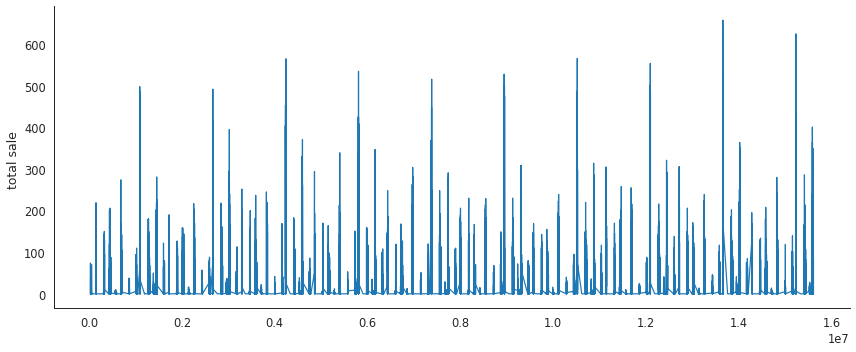

In [171]:
train.total_sales.plot(figsize=(12,5));
plt.ylabel('total sale ')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.show();

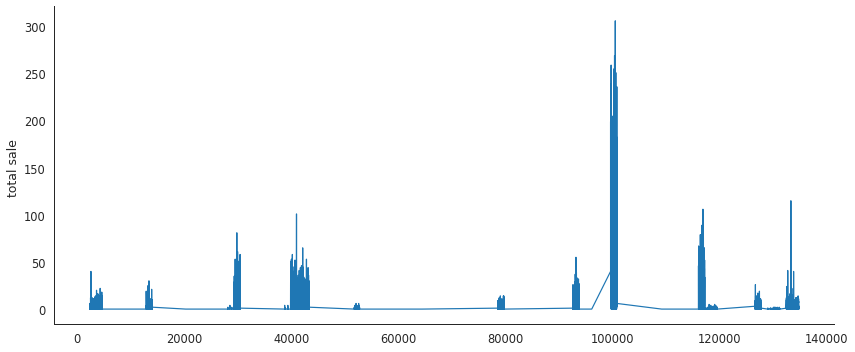

In [172]:
test.total_sales.plot(figsize=(12,5));
plt.ylabel('total sale ')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.show();

In [173]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3960188 entries, 25642 to 15610820
Data columns (total 12 columns):
 #   Column             Dtype         
---  ------             -----         
 0   total_sales        int64         
 1   is_holiday         int64         
 2   node               int64         
 3   dept_nbr           float64       
 4   cl_nbr             int64         
 5   sub_cl_nbr         int64         
 6   subclass_id        object        
 7   beginning_of_week  datetime64[ns]
 8   year               int64         
 9   month              int64         
 10  quarter            int64         
 11  week_of_year       int64         
dtypes: datetime64[ns](1), float64(1), int64(9), object(1)
memory usage: 392.8+ MB


In [174]:
train_data = data[['total_sales' , 'beginning_of_week']]

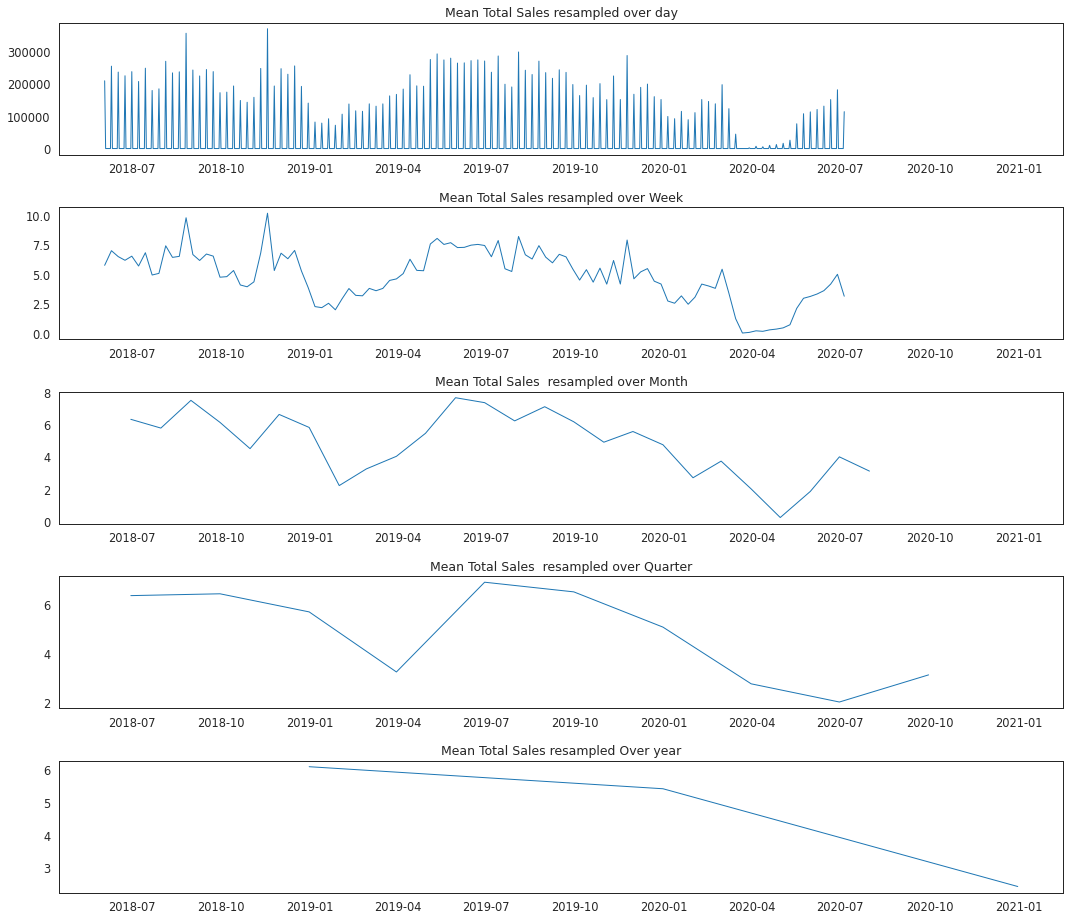

In [175]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(train_data.resample('D' , on='beginning_of_week').sum(),linewidth=1)
ax1.set_title('Mean Total Sales resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(train_data.resample('W' , on='beginning_of_week').mean(),linewidth=1)
ax2.set_title('Mean Total Sales resampled over Week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(train_data.resample('M' , on='beginning_of_week').mean(),linewidth=1)
ax3.set_title('Mean Total Sales  resampled over Month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(train_data.resample('Q' , on='beginning_of_week').mean(),linewidth=1)
ax4.set_title('Mean Total Sales  resampled over Quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(train_data.resample('A' , on='beginning_of_week').mean(),linewidth=1)
ax5.set_title('Mean Total Sales resampled Over year')
ax5.tick_params(axis='both', which='major');


In [176]:
data.columns

Index(['total_sales', 'is_holiday', 'node', 'dept_nbr', 'cl_nbr', 'sub_cl_nbr',
       'subclass_id', 'beginning_of_week', 'year', 'month', 'quarter',
       'week_of_year'],
      dtype='object')

Text(0.5, 1.0, 'Mean is_holiday by total_sale')

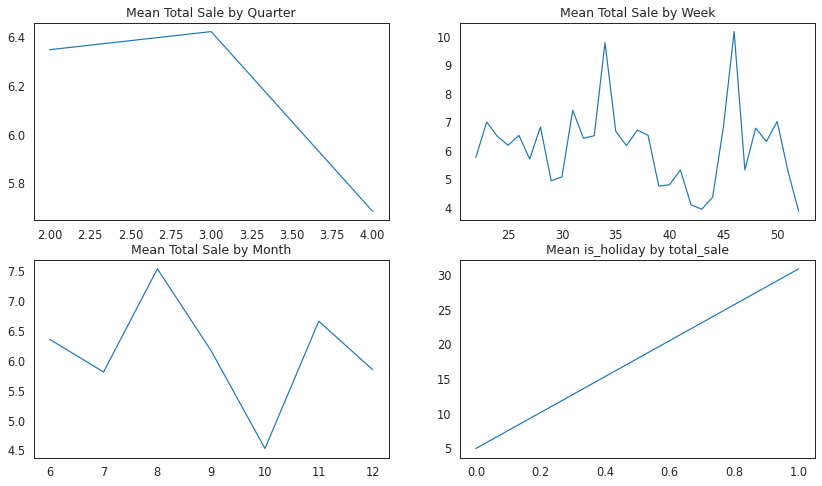

In [180]:
year = [2018]
data_2018=data.loc[data['year'].isin(year)]



plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
data_2018.groupby('quarter').total_sales.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Total Sale by Quarter')

plt.subplot(2,2,2)
data_2018.groupby('week_of_year').total_sales.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Total Sale by Week')

plt.subplot(2,2,3)
data_2018.groupby('month').total_sales.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Total Sale by Month')

plt.subplot(2,2,4)
data_2018.groupby('is_holiday').total_sales.agg('mean').plot()
plt.xlabel('')
plt.title('Mean is_holiday by total_sale')

Text(0.5, 1.0, 'Mean is_holiday by total_sale')

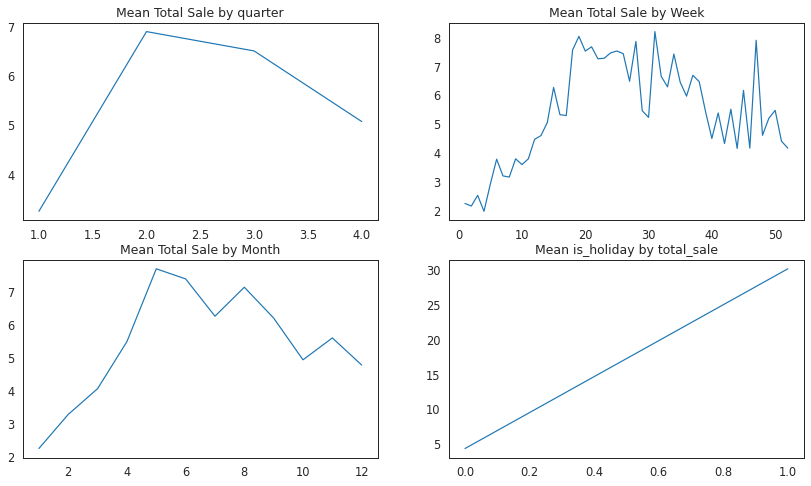

In [181]:
year = [2019]
data_2019=data.loc[data['year'].isin(year)]



plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
data_2019.groupby('quarter').total_sales.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Total Sale by quarter')

plt.subplot(2,2,2)
data_2019.groupby('week_of_year').total_sales.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Total Sale by Week')

plt.subplot(2,2,3)
data_2019.groupby('month').total_sales.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Total Sale by Month')

plt.subplot(2,2,4)
data_2019.groupby('is_holiday').total_sales.agg('mean').plot()
plt.xlabel('')
plt.title('Mean is_holiday by total_sale')

Text(0.5, 1.0, 'Mean is_holiday by total_sale')

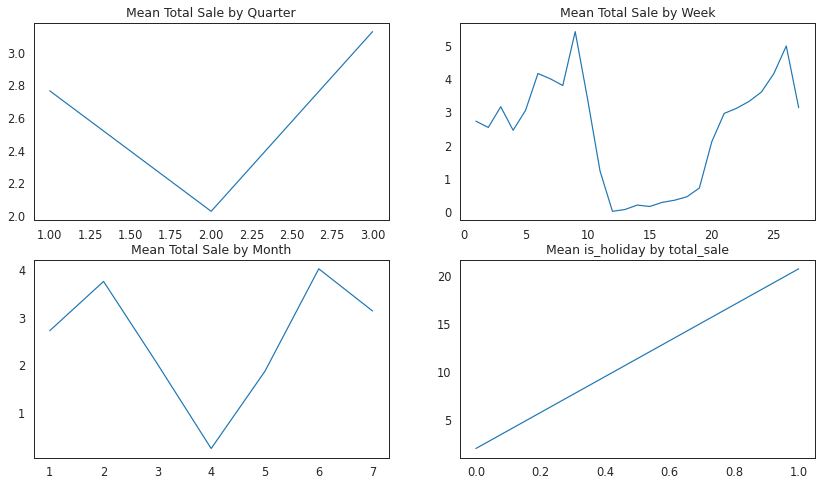

In [182]:
year = [2020]
data_2020=data.loc[data['year'].isin(year)]



plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
data_2020.groupby('quarter').total_sales.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Total Sale by Quarter')

plt.subplot(2,2,2)
data_2020.groupby('week_of_year').total_sales.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Total Sale by Week')

plt.subplot(2,2,3)
data_2020.groupby('month').total_sales.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Total Sale by Month')

plt.subplot(2,2,4)
data_2020.groupby('is_holiday').total_sales.agg('mean').plot()
plt.xlabel('')
plt.title('Mean is_holiday by total_sale')

In [183]:
data.dept_nbr.value_counts()

15.0000     2191640
543.0000    1804880
Name: dept_nbr, dtype: int64